<a href="https://colab.research.google.com/github/amolk/AGI-experiments/blob/master/Pattern%20Machine/04_Pattern_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pattern machine
- continuous, i.e. activation changes over time as decaying history of instantaneous activation
- modular, i.e. connect up more flexibly,
- use multi-patterns, i.e. pattern contains more than 1 weights tensor. This is to represent input and output jointly.

Architectural decisions
- Signal, SignalGrid, CompositeSignalGrid
- input patches may overlap when utility factor > 1, fixed number (a grid) of patterns per patch
- output neighborhood is the patterns corresponding to a neighborhood of patches

In [1]:
!pip install ipytest

     |████████████████████████████████| 286kB 7.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [2]:
%load_ext autoreload
%autoreload 1
import ipytest
ipytest.autoconfig()

In [3]:
%%writefile utils.py
import pdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

def pretty_s(name, clas, indent=0):
  if type(clas).__name__ == 'Tensor':
    return ' ' * indent + name + ":" + type(clas).__name__ + " size" + str(tuple(clas.shape))

  strs = []
  strs.append(' ' * indent + name + ":" + type(clas).__name__)

  indent += 2
  for k,v in clas.__dict__.items():
    if '__dict__' in dir(v):
      strs.append(pretty_s(k, v,indent))
    elif '__iter__' in dir(v):
      if type(v) is tuple:
        strs.append(' ' * indent + k + ' = ' + str(v))
      else:
        strs.append(' ' * indent +  k + ' = [')
        for index, item in enumerate(v):
          if '__dict__' in dir(item):
            strs.append(pretty_s(str(index), item, indent+2))
          else:
            strs.append(' ' * (indent+2) + str(item))
        strs.append(' ' * indent +  ']')
    else:
      strs.append(' ' * indent +  k + ' = ' + str(v))

  return "\n".join(strs)
          
def pretty_print(name, clas, indent=0):
  print(pretty_s(name, clas, indent))

def soft_add(a, b, tau):
  return a * (1 - tau) + b * tau

def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

def plot_patterns(patterns, pattern_lr, dataset, voronoi=False, annotate=False, figsize=(7,7), dpi=100):
  patterns = patterns.cpu()
  dataset = dataset.cpu()
  assert len(patterns.shape) == 2 # (pattern count, 2)
  assert patterns.shape[1] == 2 # 2D

  rgba_colors = torch.zeros((patterns.shape[0], 4))

  # for blue the last column needs to be one
  rgba_colors[:,2] = 1.0
  # the fourth column needs to be your alphas
  if pattern_lr is not None:
    alpha = (1.1 - pattern_lr.cpu()).clamp(0, 1) * 0.9
    rgba_colors[:, 3] = alpha
  else:
    rgba_colors[:, 3] = 1.0

  plt.figure(figsize=figsize, dpi=dpi)
  ax = plt.gca()
  ax.cla() # clear things for fresh plot

  if annotate:
    for i in range(patterns.shape[0]):
      ax.annotate(str(i), (patterns[i][0], patterns[i][1]), xytext=(5,-3), textcoords='offset points')

  ax.scatter(patterns[:, 0], patterns[:, 1], marker='.', c=rgba_colors, s=50)
  ax.scatter(dataset[:, 0], dataset[:, 1], marker='.', c='r', s=10)

  if voronoi:
    vor = Voronoi(patterns)
    vor_fig = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='gray',
                              line_width=1, line_alpha=0.2, point_size=0)

  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  plt.show()

"""
Create a numpy array of given shape, each element initialized using supplied function
Example: make_ndarray((2,3), lambda multi_index:multi_index)
"""
def make_ndarray(shape, fn):
  a = np.empty(shape, dtype=object)
  with np.nditer(a, flags=['refs_ok', 'multi_index'], op_flags=['readwrite']) as it:
    for x in it:
      a[it.multi_index] = fn(it.multi_index)

  return a

Writing utils.py


In [4]:
# !pip install matplotlib scipy
%aimport utils

In [5]:
%%writefile pattern.py

import torch
import numpy
import pdb
from typing import List, Tuple
from utils import pretty_s
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GridShapeMismatchError(Exception): pass
class NoComponentsError(Exception): pass

class SignalUtils:
  @staticmethod
  def compute_precision(variance):
    return torch.exp(-variance)

class SignalGridHP:
  def __init__(self, grid_shape:Tuple, signal_shape:Tuple, init_pixel_scale:float=0.1, init_variance:float=10):
    self.grid_shape = grid_shape
    self.grid_size = np.prod(self.grid_shape)
    if self.grid_size <= 0:
      raise ValueError("Invalid grid size")

    self.signal_shape = tuple(signal_shape)
    self.signal_size = np.prod(self.signal_shape)
    if self.signal_size <= 0:
      raise ValueError("Invalid signal size")

    self.init_pixel_scale = init_pixel_scale
    self.init_variance = init_variance

class SignalGrid:
  def __init__(self, hp:SignalGridHP, alloc_pixels=True, pixels=None):
    self.hp = hp
    if pixels is not None:
      self.pixels = pixels
    elif alloc_pixels:
      self.pixels = torch.rand((hp.grid_size, hp.signal_size)).to(device) * hp.init_pixel_scale
    else:
      self.pixels = None

    self.variance = torch.ones((hp.grid_size, hp.signal_size)).to(device) * hp.init_variance
    self.refresh_precision()

  def refresh_precision(self):
    self.precision = SignalUtils.compute_precision(self.variance)

  @property
  def signal_shape(self):
    return self.hp.signal_shape

  @property
  def __dict__(self):
    return {
        'grid_shape': self.hp.grid_shape,
        'signal_shape': self.hp.signal_shape,
        'pixels': self.pixels,
        'precision': self.precision
    }

  def __repr__(self):
    return pretty_s("", self)

class CompositeSignalGridHP:
  def __init__(self, hps:List[SignalGridHP]):
    if len(hps) == 0:
      raise NoComponentsError("Must specify at least one component")

    self.components = hps
    self.grid_shape = hps[0].grid_shape

    # all components must have same grid size
    for component_hp in hps:
      if component_hp.grid_shape != hps[0].grid_shape:
        raise GridShapeMismatchError

class CompositeSignalGrid:
  @staticmethod
  def from_pixels_list(pixels_list:List[torch.Tensor], variance:float=0.0):
    signal_hps = [SignalGridHP(grid_shape=(1,1), signal_shape=pixels.shape, init_variance=variance) for pixels in pixels_list]
    hp = CompositeSignalGridHP(hps=signal_hps)
    result = CompositeSignalGrid(hp=hp, alloc=False)
    for index, component in enumerate(result.components):
      component.pixels = pixels_list[index]
    return result

  @staticmethod
  def from_pixels_and_variances_list(pixels_list:List[torch.Tensor], variances_list:List[torch.Tensor], signal_shape:List[Tuple]):
    signal_hps = [SignalGridHP(grid_shape=(1,1), signal_shape=signal_shape[index], init_variance=0.0) for index, pixels in enumerate(pixels_list)]
    hp = CompositeSignalGridHP(hps=signal_hps)
    result = CompositeSignalGrid(hp=hp, alloc=False)
    for index, component in enumerate(result.components):
      component.pixels = pixels_list[index]
      component.variance = variances_list[index]
      component.refresh_precision()
    return result

  def from_signal_grids(signal_grids:List[SignalGrid]):
    result = CompositeSignalGrid(hp=None)
    hp = CompositeSignalGridHP(hps=[sg.hp for sg in signal_grids])
    result.hp = hp
    result.components = signal_grids
    return result

  def __init__(self, hp:CompositeSignalGridHP=None, alloc=True):
    self.hp = hp
    if hp:
      self.components = [SignalGrid(component_hp, alloc_pixels=alloc) for component_hp in hp.components]

  # add a SignalGrid as a component  
  def add_component(self, o:SignalGrid):
    assert self.hp.grid_shape == o.hp.grid_shape, f"{self.hp.grid_shape} != {o.hp.grid_shape}"

    self.hp.components.append(o.hp)
    self.components.append(o)

  @property
  def signal_shape(self):
    return [c.hp.signal_shape for c in self.components]

  @property
  def pixels(self):
    return [component.pixels for component in self.components]

  @property
  def grid_shape(self):
    return self.hp.grid_shape

  @property
  def component_count(self):
    return len(self.components)

  def __getitem__(self, index):
    pixels_list = [component.pixels[index] for component in self.components]
    variances_list = [component.variance[index] for component in self.components]

    return CompositeSignalGrid.from_pixels_and_variances_list(pixels_list, variances_list, self.signal_shape)

  def __repr__(self):
    return pretty_s("", self)

class PatternGridHP:
  def __init__(self, grid_shape, pattern_composite_signal_shape:Tuple):
    self.grid_shape = grid_shape
    self.grid_size = np.prod(self.grid_shape)

    self.composite_signal_grid_hp =  CompositeSignalGridHP(hps=[SignalGridHP(grid_shape=grid_shape, signal_shape=signal_shape) for signal_shape in pattern_composite_signal_shape])

class PatternGrid:
  def __init__(self, hp:PatternGridHP):
    self.hp = hp
    self.composite_signal_grid_begin = CompositeSignalGrid(hp.composite_signal_grid_hp) # Trajectory begin
    self.composite_signal_grid_end = CompositeSignalGrid(hp.composite_signal_grid_hp)   # Trajectory end
    self.alpha = torch.ones((hp.grid_size,)).to(device)

  def __repr__(self):
    return pretty_s("", self)

  @property
  def pixels(self):
    return [
      [component.pixels for component in self.composite_signal_grid_begin.components],
      [component.pixels for component in self.composite_signal_grid_end.components]
    ]

class PatternSimilarityHP:
  def __init__(self, enable_precision_weighted_distance=True):
    self.enable_precision_weighted_distance = enable_precision_weighted_distance

class PatternSimilarity:
  def __init__(self, signal:CompositeSignalGrid, patterns:CompositeSignalGrid, hp:PatternSimilarityHP=None):
    """
    signal must be        grid_shape=(grid_shape)                               signal_shape=(composite_signal_shapes)
    patterns must be      grid_shape=(grid_shape, per_item_pattern_grid_shape)  signal_shape=(composite_signal_shapes)

    Each signal is compared with corresponding per_x_pattern_grid_shape patterns.
    Each comparison is done across composite signal components
    """
    if hp:
      self.hp = hp
    else:
      self.hp = PatternSimilarityHP()

    assert signal.component_count == patterns.component_count, f"signal.component_count {signal.component_count} != patterns.component_count {patterns.component_count}"
    assert signal.signal_shape == patterns.signal_shape, f"signal.signal_shape {signal.signal_shape} != patterns.signal_shape {patterns.signal_shape}"
    assert patterns.grid_shape[0:len(signal.grid_shape)] == signal.grid_shape, f"patterns.grid_shape {patterns.grid_shape} must match 0-n dimensions with signal.grid_shape {signal.grid_shape}"
    per_item_pattern_grid_shape = patterns.grid_shape[len(signal.grid_shape):]
    per_item_pattern_grid_size = np.prod(per_item_pattern_grid_shape)

    self.dist_1 = []
    self.dist_d = []
    self.dist = []
    self.sim_components = []

    # find similarity based on each signal component
    for component_index in range(signal.component_count):
      x_component = signal.components[component_index]
      y_component = patterns.components[component_index]

      xs = x_component.pixels.shape
      x_component_pixels_expanded = x_component.pixels \
                                    .unsqueeze(dim=1) \
                                    .expand((xs[0], per_item_pattern_grid_size, xs[1])) \
                                    .reshape(-1, xs[1]) # expensive to reshape. How to vectorize better?
      assert x_component_pixels_expanded.shape == y_component.pixels.shape
      x_component_precision_expanded = x_component.precision \
                                    .unsqueeze(dim=1) \
                                    .expand((xs[0], per_item_pattern_grid_size, xs[1])) \
                                    .reshape(-1, xs[1]) # expensive to reshape. How to vectorize better?
      assert x_component_precision_expanded.shape == y_component.precision.shape

      dist_1_component, dist_d_component, dist_component = self.l2_distance(
          x=x_component_pixels_expanded,
          x_precision=x_component_precision_expanded,
          y=y_component.pixels,
          y_precision=y_component.precision)
      
      sim_component = torch.exp(-dist_component)

      self.dist_1.append(dist_1_component)
      self.dist_d.append(dist_d_component)
      self.dist.append(dist_component)
      self.sim_components.append(sim_component)

    # final similarity is mean of signal component similarities
    # this equalizes class weights for all components (e.g. modalities)
    self.sim = torch.stack(self.sim_components).mean(dim=0)

    # HACKHACK?! contrast enhancement
    # self.sim = self.sim - self.sim.min(dim=0).values + 0.01

  def l2_cross_distance(self, x, x_precision, y, y_precision):
    xs = x.shape
    assert len(xs) == 2
    assert (x_precision is None) or (x_precision.shape == xs), "Precision, if specified, must be same shape as patterns"

    ys = y.shape
    assert len(ys) == 2
    assert (y_precision is None) or (y_precision.shape == ys), "Precision, if specified, must be same shape as patterns"

    assert xs[1] == ys[1], "Patch size, i.e. dim 1, must match"

    n = xs[0]
    m = ys[0]
    d = xs[1]

    x = x.unsqueeze(1).expand(n, m, d)
    x_precision = x_precision.unsqueeze(1).expand(n, m, d)

    y = y.unsqueeze(0).expand(n, m, d)
    y_precision = y_precision.unsqueeze(0).expand(n, m, d)

    return self.l2_distance(x, x_precision, y, y_precision)

  def l2_distance(self, x, x_precision, y, y_precision):
    dist_1 = (x - y).abs()
    dist_d = torch.pow(dist_1, 2)

    if self.hp.enable_precision_weighted_distance:
      if x_precision is not None:
        dist_d = dist_d * x_precision

      if y_precision is not None:
        dist_d = dist_d * y_precision

    dist = dist_d.sum(-1).sqrt()
    return dist_1, dist_d, dist

  def __repr__(self):
    s = []
    s.append(f"self.dist_1: {self.dist_1}")
    return "".join(s)


Writing pattern.py


In [6]:
# !pip install torch
%aimport pattern

In [7]:
%%writefile convoluation_utils.py
import math
from pattern import *
from typing import List, Tuple
import numpy as np
import pdb

class ConvolutionUtils:
  @staticmethod
  def make_afferent_patches(signal:CompositeSignalGrid, grid_shape:Tuple, coverage_factor:float=1.0):
    # print("make_afferent_patches")
    # print("  signal", signal.signal_shape)
    # print("  grid_shape", grid_shape)
    # print("  coverage_factor", coverage_factor)

    assert signal.grid_shape == (1,1)

    if grid_shape == (1,1):
      # no convoluation
      return signal

    for grid_shape_i in grid_shape:
      assert grid_shape_i > 1

    patch_signal_grids = []

    for component_index in range(len(signal.components)):
      # print("  component", component_index)
      component = signal.components[component_index]

      patch_shape = tuple([int(coverage_factor *  component.signal_shape[i] / grid_shape[i]) for i in range(len(grid_shape))])
      # print("    patch_shape", patch_shape)
      stride = tuple([math.floor((component.signal_shape[i]-patch_shape[i])/(grid_shape[i]-1)) for i in range(len(grid_shape))])
      # print("    stride", stride)

      patches = ConvolutionUtils.conv_slice(component.pixels.view((1,) + component.hp.signal_shape), patch_shape, stride=stride).squeeze(dim=0)
      sghp = SignalGridHP(grid_shape=grid_shape, signal_shape=patch_shape)
      patch_signal_grid = SignalGrid(hp=sghp, alloc_pixels=False, pixels = patches)
               
      # print("  patch_signal_grid", patch_signal_grid)
      patch_signal_grids.append(patch_signal_grid)

    patches = CompositeSignalGrid.from_signal_grids(patch_signal_grids)
    return patches

  @staticmethod
  def conv_slice(images, kernel_shape, stride, padding=0):
    assert len(images.shape) == 3, "Must be (image count, image height, image width)"
    images = images.unsqueeze(1)

    fold_params = dict(kernel_size=kernel_shape, dilation=1, padding=padding, stride=stride)
    unfold = torch.nn.Unfold(**fold_params)
    # print("images", images.shape)
    unfolded = unfold(images)
    unfolded = unfolded.view(images.shape[0], -1, unfolded.shape[-1])
    unfolded = unfolded.transpose(1, 2)
    return unfolded

Writing convoluation_utils.py


In [8]:
%aimport convoluation_utils

In [9]:
%%run_pytest[clean]
"""
Test SignalGrid
"""

import pytest
import pdb
from pattern import *

def test_signal_grid_invalid_grid_size1():
  with pytest.raises(ValueError):
    SignalGridHP(
      grid_shape=(0,4),     # <-- zero
      signal_shape=(5,6,2)
    )

def test_signal_grid_invalid_grid_size2():
  with pytest.raises(ValueError):
    SignalGridHP(
      grid_shape=(1,4),
      signal_shape=(5,-1,2) # <-- negative
    )

@pytest.fixture
def signal_grid_hp1():
  return SignalGridHP(
      grid_shape=(3,4),
      signal_shape=(5,6,2))

@pytest.fixture
def signal_grid_hp2():
  return SignalGridHP(
      grid_shape=(3,4),
      signal_shape=(2,2))

@pytest.fixture
def signal_grid1(signal_grid_hp1):
  return SignalGrid(hp=signal_grid_hp1)

def test_create_signal_grid(signal_grid_hp1):
  signal_grid = SignalGrid(hp=signal_grid_hp1)
  assert signal_grid.pixels.shape == (3*4, 5*6*2)
  assert signal_grid.variance.shape == signal_grid.pixels.shape
  assert signal_grid.precision.shape == signal_grid.pixels.shape

@pytest.fixture
def signal_grid_hp_degenerate():
  return SignalGridHP(
      grid_shape=(1,1),
      signal_shape=(1,1))

def test_create_signal_grid_degenerate(signal_grid_hp_degenerate):
  signal_grid = SignalGrid(hp=signal_grid_hp_degenerate)
  assert signal_grid.pixels.shape == (1, 1)
  assert signal_grid.variance.shape == signal_grid.pixels.shape
  assert signal_grid.precision.shape == signal_grid.pixels.shape

def test_composite_signal_grid_from_pixels_list():
  csg = CompositeSignalGrid.from_pixels_list([torch.ones((10,10)), torch.ones((5,5))])
  assert csg.grid_shape == (1,1)
  assert len(csg.components) == 2

  c0 = csg.components[0]
  assert c0.hp.grid_shape == (1,1)
  assert c0.signal_shape == (10,10)

  c1 = csg.components[1]
  assert c1.hp.grid_shape == (1,1)
  assert c1.signal_shape == (5,5)

def test_composite_signal_grid_from_signal_grids_error1():
  grid_shape0 = (3,4)
  signal_shape0 = (5,3,2)
  grid_shape1 = (1,2)
  signal_shape1 = (12,)

  sgs = [
         SignalGrid(hp=SignalGridHP(grid_shape=grid_shape0, signal_shape=signal_shape0)), 
         SignalGrid(hp=SignalGridHP(grid_shape=grid_shape1, signal_shape=signal_shape1))
  ]
  with pytest.raises(GridShapeMismatchError):
    CompositeSignalGrid.from_signal_grids(sgs)

def test_composite_signal_grid_from_signal_grids():
  grid_shape = (3,4)
  signal_shape0 = (5,3,2)
  signal_shape1 = (12,)

  sgs = [
         SignalGrid(hp=SignalGridHP(grid_shape=grid_shape, signal_shape=signal_shape0)), 
         SignalGrid(hp=SignalGridHP(grid_shape=grid_shape, signal_shape=signal_shape1))
  ]
  csg = CompositeSignalGrid.from_signal_grids(sgs)
  
  assert csg.hp.grid_shape == grid_shape
  assert len(csg.components) == 2

  c0 = csg.components[0]
  assert c0.hp.grid_shape == grid_shape
  assert c0.signal_shape == signal_shape0

  c1 = csg.components[1]
  assert c1.hp.grid_shape == grid_shape
  assert c1.signal_shape == signal_shape1

def test_composite_signal_grid_from_pixels_and_variances_list():
  pixels_list = [torch.ones((10,10)), torch.ones((5,5))]
  variances_list = [torch.ones((10,10)), torch.ones((5,5))]

  csg = CompositeSignalGrid.from_pixels_and_variances_list(pixels_list=pixels_list, variances_list=variances_list, signal_shape=[(10,10),(5,5)])
  assert csg.grid_shape == (1,1)
  assert len(csg.components) == 2

  c0 = csg.components[0]
  assert c0.hp.grid_shape == (1,1)
  assert c0.signal_shape == (10,10)
  assert c0.pixels is pixels_list[0]
  assert c0.variance is variances_list[0]

  c1 = csg.components[1]
  assert c1.hp.grid_shape == (1,1)
  assert c1.signal_shape == (5,5)
  assert c1.pixels is pixels_list[1]
  assert c1.variance is variances_list[1]

def test_composite_signal_grid_indexing(signal_grid_hp1, signal_grid_hp2):
  csg_hp = CompositeSignalGridHP(hps=[signal_grid_hp1, signal_grid_hp2])
  csg = CompositeSignalGrid(hp=csg_hp)

  for index in range(5, 10):
    item = csg[index]
    assert item.hp.grid_shape == (1,1)
    assert len(item.hp.components) == len(csg.hp.components)
    assert item.signal_shape == csg.signal_shape



.........                                                                [100%]
9 passed in 0.17s


In [10]:
%%run_pytest[clean]
"""
Test CompositeSignalGrid
"""

import pytest
from pattern import *

def test_csg_zero_components():
  """
  Must have at least 1 component
  """
  with pytest.raises(NoComponentsError):
    CompositeSignalGridHP([])

def test_csg_different_grid_shapes():
  """
  Components may not have different grid shapes
  """
  with pytest.raises(GridShapeMismatchError):
    CompositeSignalGridHP([
      SignalGridHP(grid_shape=(1,2), signal_shape=(3,4)),
      SignalGridHP(grid_shape=(2,2), signal_shape=(3,4))
    ])

@pytest.fixture
def composite_signal_grid1():
  return CompositeSignalGrid(CompositeSignalGridHP([
    SignalGridHP(grid_shape=(1,2), signal_shape=(3,4)),
    SignalGridHP(grid_shape=(1,2), signal_shape=(3,2,1))
  ]))

def test_csg_different_signal_shapes(composite_signal_grid1):
  """
  Components may have different signal shapes
  """
  assert composite_signal_grid1.component_count == 2
  assert composite_signal_grid1.components[0].signal_shape == (3,4)
  assert composite_signal_grid1.components[1].signal_shape == (3,2,1)
  assert composite_signal_grid1.signal_shape == [(3,4), (3,2,1)]

...                                                                      [100%]
3 passed in 0.02s


In [11]:
%%run_pytest[clean]
"""
Test PatternGrid
"""

import pytest
from pattern import *

@pytest.fixture
def pg1():
  pg_hp = PatternGridHP(grid_shape=(1,2), pattern_composite_signal_shape=[(3,4),(3,2,1)])

  return PatternGrid(hp=pg_hp)

def test_pg_create(pg1):
  pg1.alpha.shape == (1,2)

@pytest.fixture
def pg2():
  pg_hp = PatternGridHP(grid_shape=(1,), pattern_composite_signal_shape=[(1,),(1,)])

  return PatternGrid(hp=pg_hp)

def test_pg_create_2(pg2):
  pg2.alpha.shape == (1,)


..                                                                       [100%]
2 passed in 0.01s


In [12]:
%%run_pytest[clean] -s
"""
Test Similarity
"""

import pytest
from pattern import *
from utils import *

def make_signal():
  pg_hp = PatternGridHP(grid_shape=(2,4), pattern_composite_signal_shape=[(3,4),(3,2,1)])
  return PatternGrid(hp=pg_hp)

def make_patterns():
  pg_hp = PatternGridHP(grid_shape=(2,4,3,2), pattern_composite_signal_shape=[(3,4),(3,2,1)])
  return PatternGrid(hp=pg_hp)

def test_sim_low_precision():
  # By default, very low precision, so equal even when pixels are random
  pgs = [make_signal(), make_patterns()]
  sim = PatternSimilarity(pgs[0].composite_signal_grid_begin, pgs[1].composite_signal_grid_begin)
  assert sim.sim.shape == pgs[1].hp.grid_size
  assert torch.allclose(sim.sim, torch.ones_like(sim.sim))

def test_sim_disable_precision_weighting():
  # If disabled precision weighting, then unequal because pixels are random
  pgs = [make_signal(), make_patterns()]
  hp = PatternSimilarityHP(enable_precision_weighted_distance=False)
  sim = PatternSimilarity(pgs[0].composite_signal_grid_begin, pgs[1].composite_signal_grid_begin, hp=hp)
  assert sim.sim.shape == pgs[1].hp.grid_size
  assert not torch.allclose(sim.sim, torch.ones_like(sim.sim))

def test_sim_high_precision():
  # If high precision, then unequal given pixels are random
  pgs = [make_signal(), make_patterns()]

  # force high precisions
  for pg in pgs:
    for component in pg.composite_signal_grid_begin.components:
      component.precision = torch.ones_like(component.precision)

  sim = PatternSimilarity(pgs[0].composite_signal_grid_begin, pgs[1].composite_signal_grid_begin)
  assert sim.sim.shape == pgs[1].hp.grid_size
  assert not torch.allclose(sim.sim, torch.ones_like(sim.sim))

...
3 passed in 0.05s


In [31]:
%%writefile layer.py

import torch
import numpy
import pdb
from typing import List, Tuple
from pattern import *
import math
from utils import *
from convoluation_utils import ConvolutionUtils

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CompositeSignalPatchGrid:
  def __init__(self, signal:CompositeSignalGrid, grid_shape:Tuple, coverage_factor=1.0):
    # signal, i.e. composite image, must be a single composite signal, i.e. its grid shape must be (1,)
    assert signal.hp.grid_shape == (1,1), f"{signal.hp.grid_shape} != (1,1)"
    self.patches:CompositeSignalGrid = ConvolutionUtils.make_afferent_patches(signal=signal, grid_shape=grid_shape, coverage_factor=coverage_factor)

class NeighborhoodPatchGrid:
  def __init__(self, signal:SignalGrid, patch_grid_shape:Tuple, per_patch_grid_shape:Tuple, patch_neighborhood_shape:Tuple):
    # signal must be a single signal, i.e. its grid shape must be (1,)
    assert signal.hp.grid_shape == (1,1), f"{signal.hp.grid_shape} != (1,1)"

    # signal shape must be flattend combination of patch_grid_shape and per_patch_grid_shape
    assert tuple(signal.hp.signal_shape) == tuple(np.multiply(patch_grid_shape, per_patch_grid_shape))

    stride = per_patch_grid_shape
    # print("  stride", stride)

    padding_patches = tuple([int((i-1)/2) for i in patch_neighborhood_shape])
    padding = tuple(np.multiply(padding_patches, per_patch_grid_shape))
    # print("  padding", padding)

    patch_shape = tuple(np.multiply(patch_neighborhood_shape, per_patch_grid_shape))
    patches = ConvolutionUtils.conv_slice(signal.pixels.view(signal.signal_shape).unsqueeze(dim=0), patch_shape, stride=stride, padding=padding).squeeze(dim=0)
    sghp = SignalGridHP(grid_shape=patch_grid_shape, signal_shape=patch_shape)
    self.patches:SignalGrid = SignalGrid(hp=sghp, alloc_pixels=False, pixels = patches)

class InputOutputPatchGrid:
  def __init__(self, patch_grid_shape:Tuple, input:CompositeSignalGrid, output:SignalGrid, output_patch_neighborhood_shape:Tuple, per_patch_pattern_grid_shape:Tuple, input_coverage_factor=1.0):
    input_grid_shape = output.signal_shape

    self.input_patches = CompositeSignalPatchGrid(signal=input, grid_shape=patch_grid_shape, coverage_factor=input_coverage_factor)
    self.output_patches = NeighborhoodPatchGrid(signal=output, patch_grid_shape=patch_grid_shape, per_patch_grid_shape=per_patch_pattern_grid_shape, patch_neighborhood_shape=output_patch_neighborhood_shape)
    
    self.patches = self.input_patches.patches
    self.patches.add_component(self.output_patches.patches)

class LayerHP:
  def __init__(self, input_signal_shapes:List[Tuple], input_coverage_factor:float, patch_grid_shape:Tuple, per_patch_pattern_grid_shape:Tuple, output_patch_neighborhood_shape:Tuple, output_tau=0.5):
    assert len(patch_grid_shape) == len(per_patch_pattern_grid_shape), "This is so that output can be flattened"
    assert len(patch_grid_shape) == len(output_patch_neighborhood_shape), "Output patch neighborhood is a subset of patch grid, so number of dimensions must match"
    # assert len(patch_grid_shape) == 2, "Currently support for 2D"

    self.input_signal_shapes:List[Tuple] = input_signal_shapes
    self.input_coverage_factor:float = input_coverage_factor
    self.patch_grid_shape:Tuple = patch_grid_shape
    self.per_patch_pattern_grid_shape:Tuple = per_patch_pattern_grid_shape
    self.output_patch_neighborhood_shape = output_patch_neighborhood_shape
    self.output_neighborhood_shape:Tuple = np.multiply(output_patch_neighborhood_shape, per_patch_pattern_grid_shape)
    self.output_tau:float = output_tau

    for size in self.output_patch_neighborhood_shape:
      assert size % 2 == 1, "Output patch neighborhood shape must be odd, so can be centered around specific output activation"

    # Get input patch shapes
    sample_input_signal = [torch.ones(shape) for shape in input_signal_shapes]
    sample_input = CompositeSignalGrid.from_pixels_list(sample_input_signal)
    patches = ConvolutionUtils.make_afferent_patches(signal=sample_input, grid_shape=patch_grid_shape, coverage_factor=input_coverage_factor)

    # Patterns -
    # each patch in the patch grid will get per_patch_pattern_grid_shape patterns, so patterns will be of shape -
    # (patch_grid_shape,) + (per_patch_pattern_grid_shape shape,) + (pattern_composite_signal_shape,)
    pattern_composite_signal_shape = patches.signal_shape + [self.output_neighborhood_shape] # input signals + output signal
    patch_grid_shape = patch_grid_shape
    pattern_grid_shape = patch_grid_shape + per_patch_pattern_grid_shape # 2D, 2D = 4D
    self.pattern_grid_hp:PatternGridHP = PatternGridHP(grid_shape=pattern_grid_shape, pattern_composite_signal_shape=pattern_composite_signal_shape)

    # Output is flattened 2D version of the 4D pattern_grid_shape
    output_shape = np.multiply(patch_grid_shape, per_patch_pattern_grid_shape) # height1*height2, width1*width2
    self.output_hp:SignalGridHP = SignalGridHP(grid_shape=(1,1), signal_shape=output_shape, init_pixel_scale=0.0)

    # print("Output shape", output_shape)

    # # input grid HP
    # hps = [
    #   SignalGridHP(
    #       grid_shape=output_shape, # Each grid element in input grid produces 1 pixel of output
    #       signal_shape=input_component.signal_shape)
    #   for input_component in patches.components # each component of input
    # ]
    # self.input_grid_hp = CompositeSignalGridHP(hps=hps.copy())

    # # pattern HP
    # hps.append(SignalGridHP(
    #     grid_shape=output_shape,
    #     signal_shape=output_neighborhood_shape))

    # self.pattern_grid_hp = PatternGridHP(
    #     grid_shape=pattern_grid_shape,
    #     composite_signal_grid_hp=CompositeSignalGridHP(hps=[
    #       SignalGridHP(grid_shape=pattern_grid_shape, signal_shape=component.signal_shape)
    #      for component in hps]))

class LocalLearning:
  def __init__(self, input:CompositeSignalGrid, output:SignalGrid, patch_grid_shape:Tuple, per_patch_pattern_grid_shape:Tuple, patterns:PatternGrid):
    # Output shape example (1, 2x3x4x5), where patch_grid_shape is (2x4) and per_patch_pattern_grid_shape is (3x5)
    assert len(patch_grid_shape) == len(per_patch_pattern_grid_shape)
    assert output.pixels.shape[0] == 1
    assert output.pixels.shape[2] == np.dot(patch_grid_shape, per_patch_pattern_grid_shape)

    activation_shape = torch.stack((torch.tensor(patch_grid_shape), torch.tensor(per_patch_pattern_grid_shape)), dim=1).view(-1) # e.g. (2, 3, 4, 5)
    activation = output.pixels.view(activation_shape)


  
class Layer:
  def __init__(self, hp:LayerHP):
    self.hp = hp
    self.patterns = PatternGrid(hp=self.hp.pattern_grid_hp)
    self.output = SignalGrid(hp.output_hp)
    self.debug = False

  def forward(self, input:CompositeSignalGrid):
    assert input.grid_shape == (1,1) # single signal input

    input_output_patch_grid = InputOutputPatchGrid(patch_grid_shape=self.hp.patch_grid_shape,
                                                   input=input,
                                                   output=self.output,
                                                   output_patch_neighborhood_shape=self.hp.output_patch_neighborhood_shape,
                                                   per_patch_pattern_grid_shape=self.hp.per_patch_pattern_grid_shape,
                                                   input_coverage_factor=1.0)
    
    # BOTTOM UP
    # Compare with pattern_end 
    self.pattern_similarity_end = PatternSimilarity(signal=input_output_patch_grid.patches, patterns=self.patterns.composite_signal_grid_end)
    if self.debug:
      print("self.pattern_similarity_end", self.pattern_similarity_end)
    
    self.activation_end = self.pattern_similarity_end.sim.unsqueeze(dim=0)
    # print("output shape", self.output.pixels.shape)
    # print("self.hp.patch_grid_shape", self.hp.patch_grid_shape)
    # print("self.hp.per_patch_pattern_grid_shape", self.hp.per_patch_pattern_grid_shape)
    assert self.output.pixels.shape == self.activation_end.shape 

    self.output.pixels = soft_add(self.output.pixels, self.activation_end, tau=self.hp.output_tau)

    # TOP DOWN
    # Compare with pattern_begin and send down winning pattern's _end as prediction
    self.pattern_similarity_begin = PatternSimilarity(signal=input_output_patch_grid.patches, patterns=self.patterns.composite_signal_grid_begin)
    if self.debug:
      print("pattern_similarity_begin", self.pattern_similarity_begin)

    assert len(self.pattern_similarity_begin.sim.shape) == 1
    # print("pattern_similarity_begin.sim", self.pattern_similarity_begin.sim)
    self.activation_begin = torch.softmax(self.pattern_similarity_begin.sim * 100, 0)
    # print("activation_begin", self.activation_begin)
    winner_index = torch.multinomial(self.activation_begin, 1)
    # print("winner_index", winner_index)
    self.top_down_prediction = self.patterns.composite_signal_grid_end[winner_index]




Overwriting layer.py


In [32]:
%aimport layer

In [33]:

%%run_pytest[clean] -s
"""
Test Layer
"""

import pytest
from utils import *
from pattern import *
from layer import *
import pdb

def test_layer_create():
  hp = LayerHP(
      input_signal_shapes=[(10,15),(20,10)],
      input_coverage_factor=1.0, 
      patch_grid_shape=(5,5),
      per_patch_pattern_grid_shape=(4,4),
      output_patch_neighborhood_shape=(3,3),
      output_tau=0.5)
  layer = Layer(hp=hp)
  # pretty_print("Layer", layer)
  assert(True)

def test_layer_forward():
  input_signal_shapes = [(10,10), (20,20)]
  input_pixels_list = [torch.ones(shape) for shape in input_signal_shapes]
  input = CompositeSignalGrid.from_pixels_list(input_pixels_list)

  hp = LayerHP(
      input_signal_shapes=input_signal_shapes,
      input_coverage_factor=1.0, 
      patch_grid_shape=(5,5),
      per_patch_pattern_grid_shape=(2,3),
      output_patch_neighborhood_shape=(3,3),
      output_tau=0.5)

  layer = Layer(hp=hp)
  #pretty_print("Layer", layer)

  for _ in range(100):
    layer.forward(input)

  assert torch.allclose(layer.output.pixels, torch.ones_like(layer.output.pixels), atol=0.01)

..
2 passed in 0.23s


pattern_machine.layer.patterns.composite_signal_grid_begin [tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]]), tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]]), tensor([[0.0290, 0.0234, 0.0375, 0.0407, 0.0653, 0.0111, 0.0630, 0.0182, 0.0119,
         0.0779],
        [0.0353, 0.0911, 0.0508, 0.0614, 0.0151, 0.0111, 0.0523, 0.0741, 0.0915,
         0.0518],
        [0.0710, 0.0121, 0.0996, 0.0245, 0.0014, 0.0412, 0.0759, 0.0946, 0.0992,
         0.0856],
        [0.0530, 0.0993, 0.0133, 0.0055, 0.0917, 0.0521, 0.0895, 0.0133, 0.0703,
         0.0149],
        [0.0392, 0.0992, 0.0298, 0.0052, 0.0686, 0.0592, 0.0007, 0.0323, 0.0337,
         0.0774],
        [0.0448, 0.0098, 0.0620, 0.0113, 0.0047, 0.0445, 0.0749, 0.0173, 0.0358,


Sample --
x, y 0.08967991173267365 0.5775052905082703
Expected prediction 0.33359259366989136
prediction (10 samples) 0.46666663885116577
prediction precision 0.11766450852155685


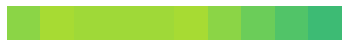


RMS Error 0.056254230594937706
Mean precision tensor(0.4477)


In [55]:
# !pip install pandas

import pandas as pd
import numpy as np
import torch
from sklearn.datasets import load_boston
from utils import *
from layer import *
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def normalize(df):
  df1 = (df - df.mean())/df.std()
  return df1

def scale(df):
  min = df.min()
  max = df.max()

  df1 = (df - min) / (max - min)
  return df1

dataset = load_boston()
dataset = pd.DataFrame(dataset.data, columns=dataset.feature_names)
dataset = pd.DataFrame(np.c_[scale(normalize(dataset['LSTAT'])), scale(normalize(dataset['RM']))], columns = ['LSTAT','RM'])
dataset = torch.tensor(dataset.to_numpy()).float().to(device)
dataset
X = dataset[:,0]
Y = dataset[:,1]

class SingleLayerRegression:
  def __init__(self, X:torch.Tensor, Y:torch.Tensor, pattern_grid_shape:Tuple=(1,10)):
    assert X.shape[0] == Y.shape[0], "Batch size must be same for X and Y"
    assert len(X.shape) >= 1, "X must be at least 1D batch of scalars"
    assert len(Y.shape) >= 1, "Y must be at least 1D batch of scalars"
    self.X = X
    self.Y = Y
    self.pattern_grid_shape = pattern_grid_shape

    self.batch_size = X.shape[0]

    # X
    self.X_signal_shape = X.shape[1:]
    if len(self.X_signal_shape) == 0:
      self.X_signal_shape = (1,1)
    elif len(self.X_signal_shape) == 1:
      self.X_signal_shape = [1] + self.X_signal_shape
    self.X_signal_shape = tuple(self.X_signal_shape)

    # Y
    self.Y_signal_shape = Y.shape[1:]
    if len(self.Y_signal_shape) == 0:
      self.Y_signal_shape = (1,1)
    elif len(self.Y_signal_shape) == 1:
      self.Y_signal_shape = [1] + self.Y_signal_shape
    self.Y_signal_shape = tuple(self.Y_signal_shape)

    # Layer
    self.layer_hp = self.create_layer_hp(per_patch_pattern_grid_shape=pattern_grid_shape)
    self.layer = Layer(hp=self.layer_hp)


  def create_layer_hp(self, input_coverage_factor=1.0, patch_grid_shape=(1,1), per_patch_pattern_grid_shape=(1, 10), output_patch_neighborhood_shape=(1,1), output_tau=1.0):
    hp = LayerHP(
          input_signal_shapes=[self.X_signal_shape, self.Y_signal_shape],
          input_coverage_factor=input_coverage_factor, 
          patch_grid_shape=patch_grid_shape,
          per_patch_pattern_grid_shape=per_patch_pattern_grid_shape,
          output_patch_neighborhood_shape=output_patch_neighborhood_shape,
          output_tau=output_tau) # set output_tau=1.0 for IID data
    return hp

  def epoch(self):
    error = 0
    prec = 0

    for i in tqdm(range(self.batch_size)):
      input = CompositeSignalGrid.from_pixels_list([self.X[i].view(self.X_signal_shape), self.Y[i].view(self.Y_signal_shape)])
      for component in input.components:
        component.variance *= 0
        component.refresh_precision()

      self.layer.forward(input)

      predictions = []
      sample_count = 10
      winner_indices = torch.multinomial(self.layer.activation_begin, sample_count, replacement=True)
      for winner_index in winner_indices:
        # print("winner_index", winner_index)
        top_down_prediction = self.layer.patterns.composite_signal_grid_end[winner_index]
        # print("prediction", top_down_prediction.components[1].pixels)
        predictions.append(top_down_prediction.components[1].pixels)

      expected = (self.X[i] + self.Y[i]).item()/2.0
      predictions = torch.stack(predictions)
      variance = torch.var(predictions)
      precision = SignalUtils.compute_precision(variance * 100)
      prediction = predictions.mean(dim=0)
      error = error + (prediction.item() - expected) ** 2
      prec = prec + precision

      if i < 1:
        print("Sample --")
        print("x, y", input.pixels[0].item(), input.pixels[1].item())
        print("Expected prediction", expected)
        print(f"prediction ({sample_count} samples)", prediction.item())
        print("prediction precision", precision.item())

        # print("layer output", self.layer.output.pixels.view(self.layer.hp.per_patch_pattern_grid_shape))
        plt.imshow(self.layer.output.pixels.view(self.layer.hp.per_patch_pattern_grid_shape), vmin=0, vmax=1, cmap=plt.cm.viridis)
        plt.axis('off')
        plt.show()


      # print("patterns", self.layer.patterns.pixels)
    print("RMS Error", (error / self.batch_size) ** 0.5)
    print("Mean precision", prec / self.batch_size)

pattern_machine = SingleLayerRegression(X, Y)
pattern_machine.layer.debug = False

# preset patterns with x and y as (0.0, 0.0) to (1.0, 1.0), i.e. y=x
for csgb in [pattern_machine.layer.patterns.composite_signal_grid_begin, pattern_machine.layer.patterns.composite_signal_grid_end]:
  csgb.components[0].pixels = torch.linspace(0, 1, 10).unsqueeze(1)
  csgb.components[1].pixels = torch.linspace(0, 1, 10).unsqueeze(1)
  csgb.components[0].variance = torch.zeros_like(csgb.components[0].variance)
  csgb.components[1].variance = torch.zeros_like(csgb.components[0].variance)
  csgb.components[0].refresh_precision()
  csgb.components[1].refresh_precision()

print("pattern_machine.layer.patterns.composite_signal_grid_begin", pattern_machine.layer.patterns.composite_signal_grid_begin.pixels)
pattern_machine.epoch()


# Discussion


*   Trajectory beginnings of patterns are hardcoded as (0,0), (0.11, 0.11), (0.22, 0.22), ..., where the two numbers are values of X and Y modality. Trajectory endings are set to the same values as well.
*   When X and Y are same, e.g. 0.33, then only that pattern is consistently the winner over multiple samples and the Y component of the end of trajectory is consistently 0.33, giving prediction 0.33 with 1.0 precision.
*   When X and Y are different, e.g. 0.1 and 0.6, then we get both the (0.11, 0.11) pattern and (0.66, 0.66) pattern competing to be winner. As a result, sampling for winners and averaging Y component of the end of trajectory of those winners produces approximately the mean of 0.1 and 0.6, and precision is lower than 1.0.

This shows that the Pattern Machine can act as a regression model.

Next up, set up a PM that embodies a 1D bouncing ball (1 tall, few wide, left to right to left ball movement). Implement hippocalmpal theta-like cyclic top down future trajectory predictions.